# 単回帰

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

In [4]:
# 分析対象となる気温とビールの売上データ
beer = pd.read_csv('beer.csv')

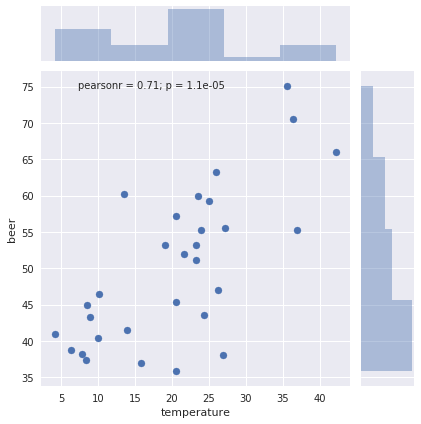

In [5]:
sns.jointplot(x='temperature', y='beer', data=beer)

### ■ 今回構築するモデル

応答変数にビールの売上を、説明変数に気温を用いた正規線形モデルを構築する。

ビールの売上 ~ N( $ {\beta}_0 $ + $ {\beta}_1 $ × 気温, $ {\sigma}^2 $ )

今回は説明変数がひとつしかないため、モデルの特定は「気温がモデルに組み込まれるか否か」を判断することになる。<br>
パラメータ推定の対象は $ {\beta}_0 $, $ {\beta}_1 $ のふたつ。


#### モデルを構築することで得られるメリット

- 実世界の現象の解釈が可能になる
    - 係数 $ {\beta}_1 $ が 0 でないと判断できれば、「ビールの売上は気温の影響を受けている」と判断できる
    - AIC によるモデル選択の文脈で言えば、「ビールの売上予測において気温という説明変数は有用」と解釈できる。
    - また、係数 $ {\beta}_1 $ の正負が分かれば、ビールの売上との相関関係が分かる。
- 予測が可能になる
    - 係数と気温が分かれば、ビールの売上の期待値が計算できるようになる。

----

In [6]:
# モデルの特定とパラメータ推定
lm_model = smf.ols(formula='beer ~ temperature', data=beer).fit()

In [7]:
# 推定結果の表示
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           1.11e-05
Time:                        12:04:41   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ■ 結果の見方
----
- Dep. Variable：応答変数の名前
- Model：通常最小二乗法
- No.Observations：サンプルサイズ
- Df Residuals：サンプルサイズから「推定されたパラメータの数」を引いた値
- Df Model：用いられた説明変数の数
- R-squared：決定係数
- Adj. R-squared：自由度調整済み決定係数
- F-statistic：F比
- Prob(F-statistic)：分散分析の p 値
- Log-Likelihood：最大化対数尤度
- AIC：情報量規準
----
- Intercept：切片
- coef：係数・切片の値
- P>|t|：帰無仮説を「係数の値が 0 である」としたときの p 値
----
- Prob(Omnibus) & Prob(JB)：残差の正規性の検定結果
    - 帰無仮説：残差は正規分布に従っている
    - 対立仮説：残差は正規分布と異なる
    - この p 値が 0.05 よりも大きいことを確認することで、明らかな問題がないことを確認できる。
- Skew & Kurtosis：歪度と尖度
    - 歪度：ヒストグラムの左右非対称さを測る指標（0 より大きいと左に寄る。正規分布は歪度 0。）
    - 尖度：ヒストグラムの中心部分の尖り具合を測る指標（大きいほど尖る。正規分布は尖度 3。）
- Durbin-Watson：残差の自己相関チェックの指標。
    - 2前後であれば自己相関がないと判断できる
    - 時系列データを対象とする分析は必ずチェックする
    - この統計量が 2 より大きくずれていれば、一般化最小二乗法の使用等を検討する必要がある

In [8]:
# AIC による変数選択（モデル選択）を手動で実行してみる

# Null モデル
null_model = smf.ols('beer ~ 1', data=beer).fit()
print('Null Model AIC: {:.3f}'.format(null_model.aic))

# 気温ありモデル
temp_model = smf.ols('beer ~ temperature', data=beer).fit()
print('Temperature Model AIC: {:.3f}'.format(temp_model.aic))

# 気温ありモデルの AIC の方が小さいので、説明変数に気温は必要と判断できる

Null Model AIC: 227.942
Temperature Model AIC: 208.909


----
AIC は以下のように計算される。

```
AIC = -2 ×（最大化対数尤度 - 推定されたパラメータの個数）
```

In [9]:
# 最大化対数尤度
print('llf: {:.3f}'.format(temp_model.llf))

# 用いられた説明変数の数 + 切片　が推定されたパラメータの数
print('#params: {:.3f}'.format(temp_model.df_model + 1))

# AIC
aic = -2* (lm_model.llf - (temp_model.df_model + 1))
print('AIC: {:.3f}'.format(aic))

llf: -102.455
#params: 2.000
AIC: 208.909


----
### ■ 回帰曲線の図示

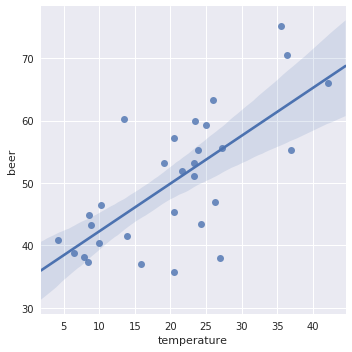

In [10]:
# モデルを使わなくても図示は可能
sns.lmplot(
    x='temperature',
    y='beer',
    data=beer
)

[ 50.3014808   53.74590495  42.26449113  55.20021737  46.70397114
  37.82501112  44.94348769  54.51133254  52.44467805  41.11634975
  54.66441806  49.22988218  53.21010564  52.44467805  41.03980699
  52.59776357  45.24965873  61.78289462  55.42984564  50.3014808
  42.41757665  50.3014808   51.14345115  40.6570932   66.91125946
  52.9039346   62.85449324  41.42252079  62.47177945  39.50895182]


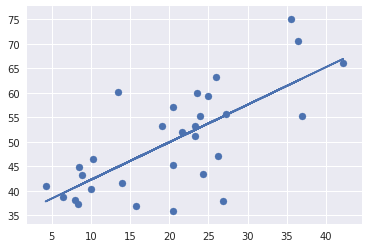

In [11]:
# モデルによる予測

# 当てはめの予測結果
pred = lm_model.predict()
print(pred)

# モデルによる予測を明示的に指定してプロットする
plt.plot(beer['temperature'], pred)
plt.scatter(beer['temperature'], beer['beer'])

In [12]:
# 気温（temperature）の値を指定して予測
lm_model.predict(pd.DataFrame({'temperature': [0]}))  # 0℃の予測は切片と一致する

0    34.610215
dtype: float64

----
### ■ モデルの評価

モデルの評価は主に残差のチェックを通して行われる。<br>
今回の正規線形モデルの場合は、残差が平均 0 の正規分布に従うはずなのでそのチェックを行う。

※実際には予測の前に評価を行うべき。

In [13]:
# 残差の取得
resid = lm_model.resid
print('resid: \n{}'.format(resid.head()))


# 手で求めてみる
beta0 = lm_model.params[0]
beta1 = lm_model.params[1]

y_hat = beta0 + beta1 * beer['temperature']
resid_manual = beer['beer'] - y_hat
print('\nresid(manual): \n{}'.format(resid_manual.head()))

resid: 
0    -5.001481
1     5.554095
2    -1.864491
3   -17.200217
4    -9.703971
dtype: float64

resid(manual): 
0    -5.001481
1     5.554095
2    -1.864491
3   -17.200217
4    -9.703971
dtype: float64


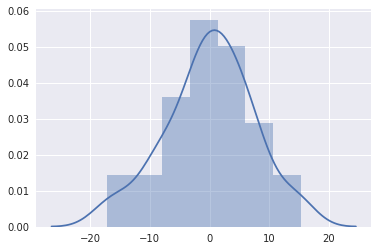

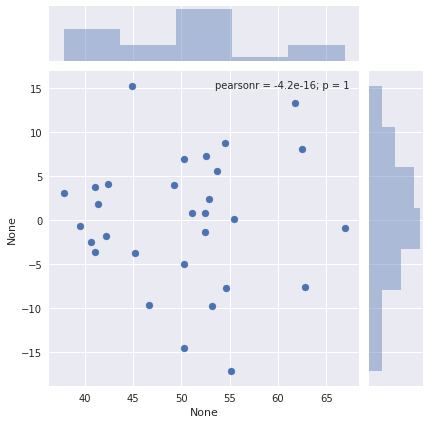

In [14]:
# 残差の図示
sns.distplot(resid)

# 当てはめの値と残差に相関がないことも確認しておく
sns.jointplot(lm_model.fittedvalues, resid)

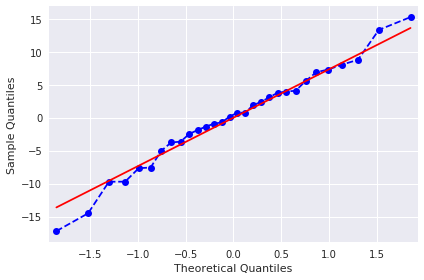

In [15]:
# Q-Q プロット
# すべてのデータに対する分位点と、理論上の正規分布の分位点とを比較するグラフ
sm.qqplot(resid, line='s', linestyle='--')
plt.tight_layout()

----
### ■ 決定係数

手持ちデータへのモデルの当てはめの度合いを評価した指標。<br>
1 に近いほど良い。

In [16]:
# R^2
print('R^2: {:.3f}'.format(lm_model.rsquared))

# 手で求めてみる
mu = sp.mean(beer['beer'])
y = beer['beer']
y_hat = lm_model.predict()

print('R^2(manual): {:.3f}'.format(sp.sum((y_hat - mu) ** 2) / sp.sum((y - mu) ** 2)))

R^2: 0.504
R^2(manual): 0.504


In [17]:
print('unexpressed variation: {:.3f}'.format(sp.sum((y_hat - mu) ** 2) + sp.sum(resid ** 2)))
print('actual variation: {:.3f}'.format(sp.sum((y - mu) ** 2)))

1 - sp.sum(resid ** 2) / sp.sum((y - mu) ** 2)

unexpressed variation: 3277.115
actual variation: 3277.115


0.503959323061186

----
### ■ 自由度調整済み決定係数

説明変数の増加に対する罰則を組み込んだ決定係数。<br>
過学習に対するケアとして確認すべき指標。<br>
1 に近いほど良い。

In [18]:
# Adjusted R^2
print('Adj R^2: {:.3f}'.format(lm_model.rsquared_adj))

# 手で求めてみる
n = len(beer['beer'])
s = lm_model.df_model
adj_r2_manual = 1 - ((sp.sum(resid ** 2) / (n - s - 1)) / (sp.sum((y - mu) ** 2) / (n - 1)))

print('Adj R^2(manual): {:.3f}'.format(adj_r2_manual))

Adj R^2: 0.486
Adj R^2(manual): 0.486
